# General Instructions

Students are allowed to work on this exercise in pairs. Make sure you have formed a group in Canvas with your partner. Each student is responsible for following the [Code of Conduct](https://kth.instructure.com/courses/32018/pages/code-of-conduct). In particular (1) All members of a group are responsible for the group's work, (2) Every student shall honestly disclose any help received and sources used, and (3) Do not copy from other people's solutions.

If you need assistance with the exercise, you are encouraged to post a question to the appropriate [Discussion Topic](https://kth.instructure.com/courses/32018/discussion_topics) or sign up for a help session.

<br>

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and delete the `raise NotImplementedError()` once you have implemented the solution

<br>

You should not import any libraries on top of the ones included in the assignment. Derivation questions can be answered using $\LaTeX$, or you may upload an image of your derivation. To do so in *Google Colab* simply create a text cell, click on the `insert image` icon, and upload an image to the notebook as we have demonstrated below.

<br>

**Submission** - once you have completed the exercise make sure everything runs as expected by going into `Runtime` -> `Restart and Run all` then download the notebook by clicking `file` -> `download` -> `download .ipynb`. Then **rename the file to include your name** (and **your partner's name** if you have one) as follows

<br>

`Ex??_LASTNAME_FIRSTNAME_and_LASTNAME_FIRSTNAME.ipynb`

<br>

where you replace `??` with the correct exercise number. If you are working alone you do not need to include a partner name. Correctly naming the file and including your name (and your partner's) below is worth **1 point** - if you fail to correctly name the file or include your partner's name, *you will lose this point*.

<br>

Good luck!

# Name (1 pts)
**Fill in your name and your partner's name below** (and name the `.ipynb` file correctly): <font color="red"> (1 Point) </font>


### Student: LAST, FIRST

### Partner: LAST, FIRST

# Exercise 9: Data generation (9 pts)

In this exercise, you will train a few very simple models for data generation, and see some of the basic principles of data generation in action.

_Note:_<br/>
The methods you will be using in this exercise are far from being state of the art. They are only intended as teaching tool, and to avoid the time required to train a deep generative model. You can take it as a fun challenge to come up with new ideas for how to improve the approaches you consider work on here.

***A few things to think about before you start:***

What is the gold standard of evaluation of generative models?

Why is it important to evaluate synthetic data before using it for training machine learning models?

What is the concept of "mode collapse" in the context of synthetic data generation?

In [ ]:
import numpy as np
import random
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
SEED=1234
np.random.seed(SEED)
random.seed(SEED)

## 9.1 Loading and visualising the dataset

We begin by loading the data for the exericse. The data is a subset of the Labeled Faces in the Wild database (Huang et al., 2007), containing monochrome photographs of human faces. Each image is labelled to identify different photographs of the same person.

For simplicity, we only load the data from the 500 persons with the most images in the data. These are usually various celebrities. You might recognise a few of them.

_Note:_<br/>
Loading the data might take some time during the first run.

In [ ]:
def load_dataset():
    X, y = fetch_lfw_people(return_X_y=True)
    X = X * 255
    X = X.round()
    # Reducing size of the dataset with the 500 most frequent labels
    unique, counts = np.unique(y, return_counts=True)
    labels_to_keep = np.argpartition(counts, -500)[-500:]
    X_ = []
    for label in labels_to_keep:
        indexes = (y == label)
        X_.append(X[indexes])
    X = np.concatenate(X_)
    np.random.shuffle(X)
    return X

X = load_dataset()
image_shape = (62, 47)

print(np.shape(X))

(6293, 2914)


The images are 62 pixels tall and 47 pixels wide, for a total of 2914 pixels (2914 elements in the feature vector for each observation).

Let's visualise a few training examples, randomly selected from the training database, to see what they look like.

_Hint:_<br/>
Take note of what the code looks like, since you will have to plot the data yourself later. In particular, we use `np.reshape` to reshape the vector to a matrix and `plotting_axis.imshow` to actuall plot the images in matplotlib. We also pass `cmap='gray', vmin=0, vmax=255` as parameters to `imshow`, otherwise the faces will all look like the Hulk.

***Something to think about:***

why are PCA the components referred to as "eigenfaces" when applied to image data of faces?

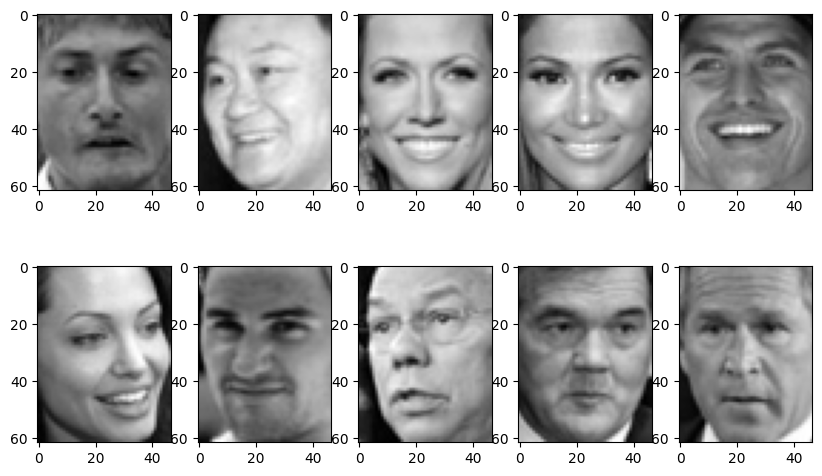

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for i in range(10):
    plotting_axis = ax[i//5][i % 5]
    plotting_axis.imshow(X[i].reshape(*image_shape), cmap='gray')
plt.show()

Let's also visualise the average of all images in the database.

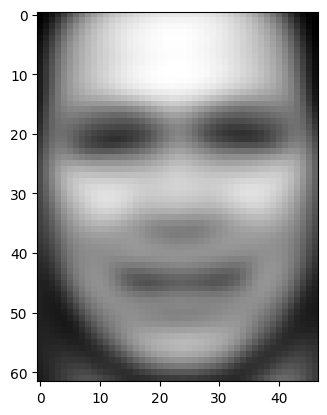

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.imshow(X.mean(0).reshape(image_shape), cmap='gray')
plt.show()

**Question 9.1.1:**<br/>
Name one or two ways that the above average image visually differs from real faces in the databases. <font color="red"> (1 pts) </font>

For a start, the image of the average is quite blurry and unclear, and it is difficult to make out any specific features.

This average image is actually the “face” that minimises the mean squared error when compared to all the images in the training database.

Obviously, a deterministic model like this is not a good fit for unconditional face synthesis. This is not unexpected, since there is a lot of variation in the database, as seen from the examples we plotted.

## 9.2 A simple, Gaussian model (4 pts total)

In this part, we will fit a simple generative probabilistic model to the data. In fact, we will use a Gaussian distribution, since that's the first distribution that basically everyone who ever studied probability tends to think of.

_Remark:_<br/>
Again, this model is too simple to make sense in practice, but it is interesting to see what happens. Also, it is generally a better idea to start from a simple model and then add complexity, rather than the other way around.

 ***Something to think about:***
 What is the main limitation of using a simple Gaussian distribution to model image data?


Can we even describe this data using a Gaussian distribution? Let's take a look at the numerical values in the data.

In [ ]:
print(X[0])
print(X[1])

[85. 82. 80. ... 85. 84. 80.]
[ 34.  35.  37. ... 193. 200. 197.]


**Task 9.2.1**:<br/>
Print the biggest and smallest value in the entire dataset. <font color="red"> (1 pts) </font>

In [ ]:
# YOUR CODE HERE
largest = np.max(X)
smallest = np.min(X)
print(largest)
print(smallest)

255.0
0.0


### Dequantisation

Many image models (perhaps even most of them) treat images as continuous data. For this to work they apply something known as _dequantisation_, and we will do the same here.

**Task 9.2.2**:<br/>
Add independent uniform noise on $[0,1)$ to every element in the dataset and store the result in `X_deq`. We have added code to print the values from a few example images after dequantisation. <font color="red"> (1 pts) </font>

_Note:_<br/>
Dequantisation is not strictly necessary in this exercise because the models we use are so simple, but it's considered best practise for image data, so we recommend that you always do it.

In [ ]:
np.random.seed(SEED)

# YOUR CODE HERE
X_deq = X + np.random.uniform(0, 1, X.shape)
print(X_deq[0])
print(X_deq[1])

[85.19151945 82.62210877 80.43772774 ... 85.40702017 84.10867293
 80.47702361]
[ 34.98224387  35.0668809   37.85224961 ... 193.88630613 200.33968012
 197.4799028 ]


Note that the new values only differ from the values printed earlier in their decimal part. (If not, you might have made a mistake, so go back and check your approach again.)

If everything looks good, we will now overwrite `X` with the new `X_deq`, to use the dequantised data from now on.

In [ ]:
X = X_deq

_Remark:_<br/>
Even though dequantisation is likely not to have much of an effect on the results in this exercise, it can be very important when working with deep generative models. It should therefore be a part of every data-processing pipeline when using continuous distributions to model image data.

### Parameter estimation

Next, we will fit a Gaussian to the dequantised dataset.

First, let us define $\mathcal X$ as the set of all training images, and let $\mathcal X_j$ be the values for pixel (element) in this training data. The former contains vectors $x_i\in\mathbb R^{hw}$, the latter contains scalar values $x_{ij}\in\mathbb R$ (for $j\in\{1,\ldots,hw\}$).

**Task 9.2.3:**<br/>
Assume that each pixel is Gaussian distributed and independent of all other pixels. Show that the MLE $\widehat\theta_{\mathrm{ML}}(\mathcal X)$ in this case can be written in terms of the MLE of $\theta_j=(\mu_j,\sigma_j)$ computed from each pixel’s dataset $\mathcal X_j$. <font color="red"> (1 pts) </font>

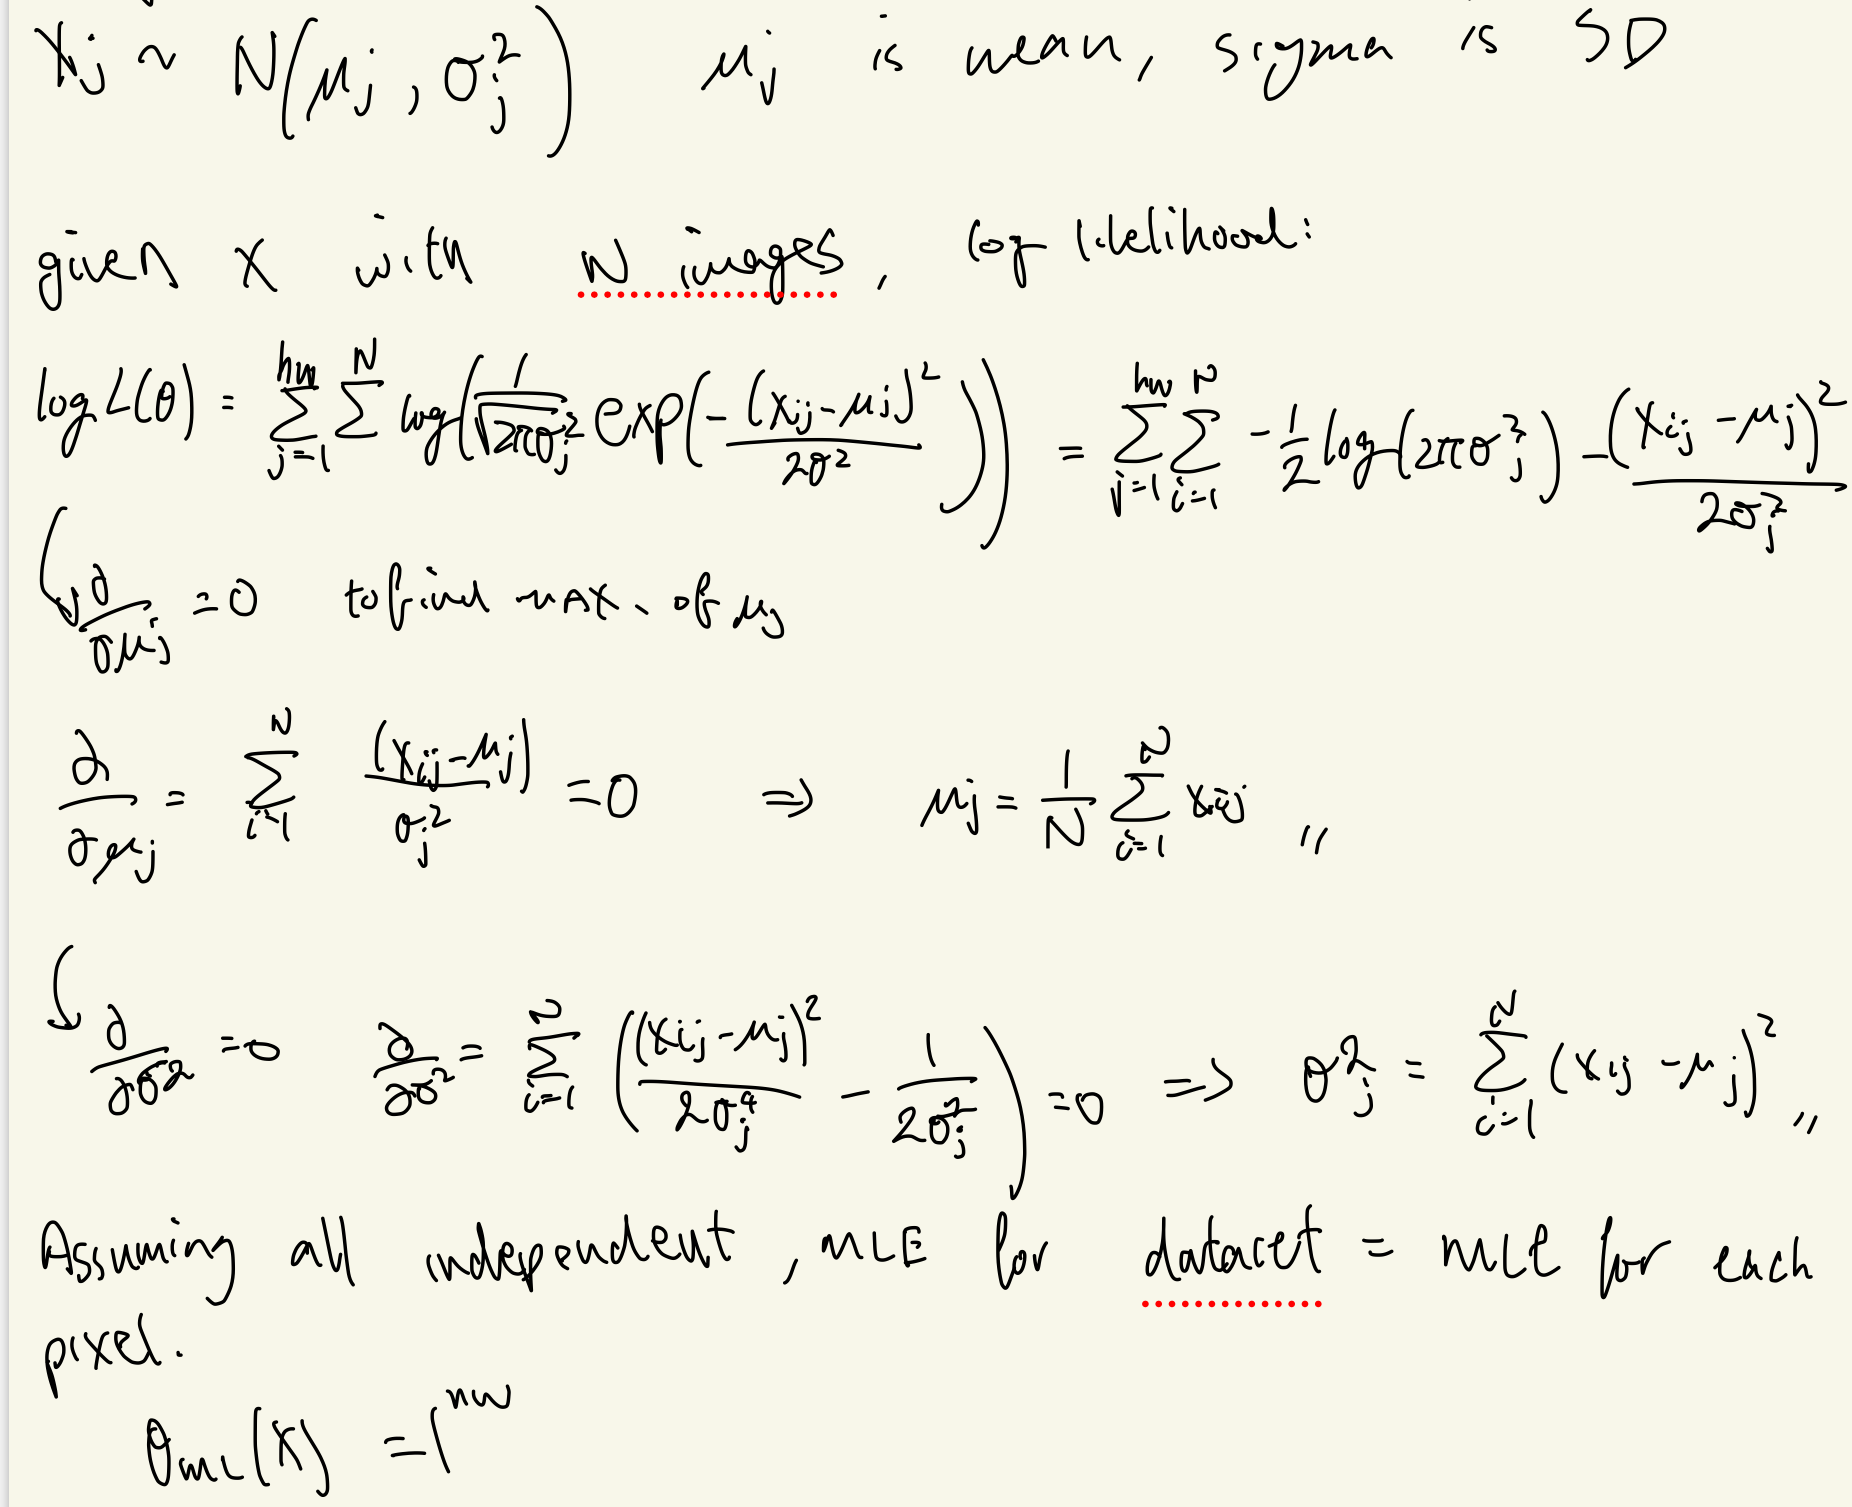

**Task 9.2.4**:<br/>
Use the above result together with the standard formulas for maximum likelihood estimation of scalar Gaussian distributions, to compute the MLE parameter estimate $\widehat\theta_{\mathrm{ML}}(\mathcal X)$ for this model, where each pixel is independently Gaussian distributed. <font color="red"> (1 pts) </font>

In [ ]:
# YOUR CODE HERE
X_j_mu = np.mean(X, axis=0)
X_j_std = np.std(X, axis=0)

### Generating output

Now let's see what we get if we sample output from this distribution.

**Task 9.2.5**:<br/>
Use the command `np.random.randn()` to implement the function `sample_from_normal` below, which samples an instance from the fitted Gaussian distribution. `np.random.randn()` generates a matrix of independent samples from the (scalar) standard normal distribution. <font color="red"> (1 pts) </font>

_Note:_<br/>
Your implementation must use `np.random.randn()`.

_Hint:_<br/>
You need to change the location and scale of the random samples in order to transform them from $\mathcal{N}(0, 1)$ to samples from a Gaussian with the required mean and standard deviation, $x_j\sim\mathcal{N}(\mu_j, \sigma_j)$. This is the basis of something known as the “reparametrisation trick” in variational autoencoders.

Something to think about:

Why can lowering the entropy of a generative model get more appealing output when sampling?

In [ ]:
def sample_from_normal():
    global X_j_mu
    global X_j_std
    # YOUR CODE HERE
    Z = np.random.randn(*X_j_mu.shape)
    return X_j_mu + Z * X_j_std

In [ ]:
# Please do not edit these testcases
np.random.seed(SEED)
test_sample = sample_from_normal()
assert np.isclose(test_sample.mean(), 127.23515, atol=1e-4), "Did you set the location and scaling of the Gaussian correctly?"
assert np.isclose(test_sample.std(), 46.74192, atol=1e-4), "Invalid implementation, please check the scaling again."

Let's visualise some random samples from this Gaussian model of facial images.

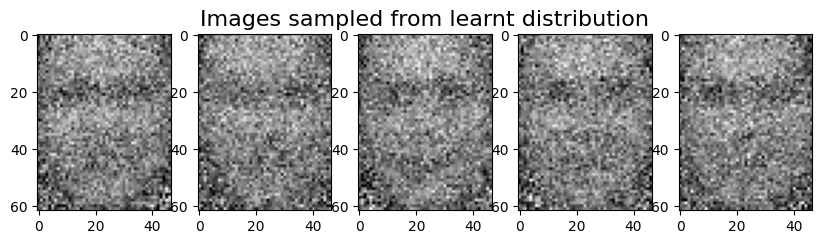

In [ ]:
samples = [sample_from_normal() for _ in range(5)]

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(samples[i].clip(0, 256).reshape(image_shape), cmap='gray', vmin=0, vmax=255)
ax[2].set_title("Images sampled from learnt distribution", fontsize=16)
plt.show()

**Question 9.2.6:**<br/>
Are the images better or worse than the mean image you visualised earlier? Describe the main problem with the images. <font color="red"> (1 pts) </font>

They are now extremely pixelated, and not even a single feature can be identified from the images.

## 9.3 Improving the approach

We will now look at how we can improve our image model.

You might have noticed a lot of noise in your sampled images, a bit like a snowstorm. The problem here is that we assumed that, for each pixel, the difference from the mean value was independent of every other pixel. That is not true in practice. If a pixel is very bright (for example, it is part of someone's teeth in a gleaming smile) it is very likely that nearby pixels also are teeth, and also are brighter than the average. This simple reasoning shows that our model is much too simplistic for this data, since it ignores correlations.

### Representing the data in a way that better fits our model

How can we get better images? It seems like one straightforward idea would be to include correlations between pixels into the model, by fitting a multivariate Gaussian with a full (instead of diagonal) covariance matrix to the pixel data. However, this would involve estimating a covariance matrix with $2914^2\approx 8,500,000$ elements, which is really big.

Instead of adding correlations to the model, another idea is to _remove_ correlations from the _data_. For uncorrelated data, a model that ignores correlations should do a lot better. You might recall from the geometry module that principal component analysis, PCA, turns correlated data into uncorrelated features. More specifically, the principal components are orthogonal vectors, and the PCA are coefficients mutually uncorrelated. These coefficients can therefore be described well by a simple Gaussian with diagonal covariance. Crucially, principal components can be “inverted”, in the sense that we can recreate the data/images from the PCA coefficients. Thus, a model that generates PCA coefficients also generates face images.

As a bonus, we can do dimensionality reduction, since most of what is going on in the data (most of the variation) is described by the first components from the PCA, and we can reconstruct close approximations of all images from their leading PCA coefficients.

We have arrived at the following overall approach:
1. Start from image data
2. Apply PCA with $K$ components to the data
3. Each image is now described by $K$ uncorrelated numbers (coefficients), that describe how much of each component we need to take to reconstruct that specific image from the components
4. Fit a multivariate Gaussian with diagonal covariance to the PCA coefficient data
5. Sample new coefficients from the model
6. Reconstruct images from the randomly sampled coefficients using the inverse PCA

Because the components in the PCA affect multiple pixels, the pixels in the sampled output images are now correlated, and should look less noisy.

Let's now take the first step and apply PCA to the data. We will take $K=250$ components, which should capture nearly all of the variation in the dataset.

_Important:_<br/>
We use an underscore after variable and function names `_` to denote PCA. For example, `X_` contains the coefficients that describe the images in PCA space. The variable `pca` contains a representation of the PCA, including the principal components themselves.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_components = 250

pca = PCA(n_components, random_state=SEED)
X_ = pca.fit_transform(X)

Let's visualise the principal axes (components) in image space. The images we get describe the directions of maximum variance in the data, in descending order. The resulting images are often called _eigenfaces_, since they are computed using a kind of eigenvector analysis under the hood.

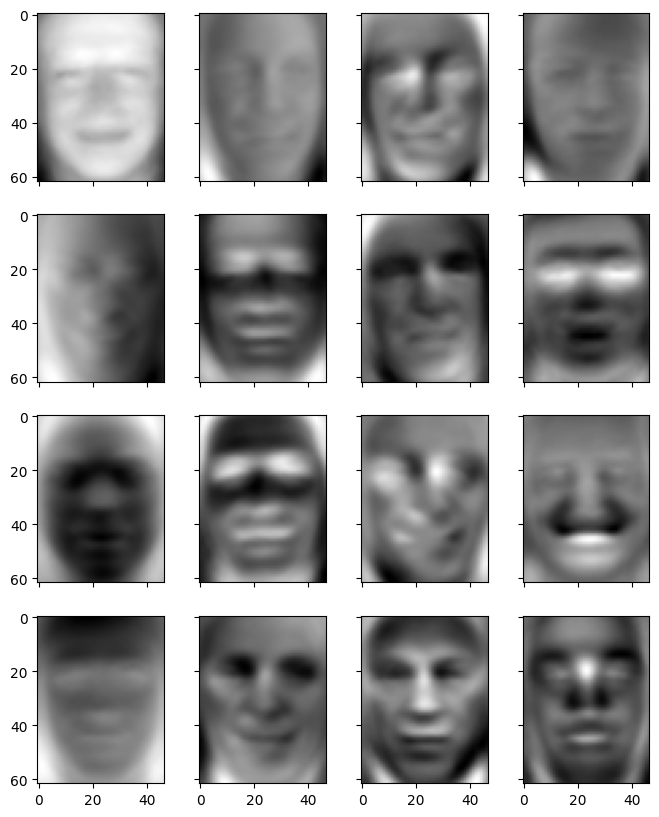

In [ ]:
eigenfaces = pca.components_[:n_components]

# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(image_shape), cmap="gray")
plt.show()

We can see that the eigenface images are blurry, since they have been averaged across many different faces. Nonetheless, we can tell that all of them are related to faces, and they can be combined in different ways to build pictures of different faces.

With a little imagination, we can give an interpretation regarding what kind of variation that some of these components describe.

**Question 9.3.1:**<br/>
Which component (image) above would you expect to show up a lot in images of faces wearing sunglasses? Give your answer as a number, where 1, 2, 3, 4 are the images in the first row (from left to right), 5, 6, 7, 8 are the images in the second row (again from left to right), and so on. <font color="red"> (1 pts) </font>

In [ ]:
sunglasses_image_number = 0
# YOUR CODE HERE
# perhaps sunglasses appear in the ones with random bright areas over their eyes, such as image 8 and 10.
# Other possible choices, but slightly less convincing, are 3 and 11

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

**Task 9.3.2**:<br/>
Fit a new model to the PCA data $\mathcal X_{\mathrm{PCA}}$, assuming that each coefficient is independently Gaussian distributed. This gives the MLE parameter estimate $\widehat\theta_{\mathrm{ML}}(\mathcal X_{\mathrm{PCA}})$. It's the same approach and formulas that you used earlier, just applied to a different set of numbers (PCA coefficients instead of pixels). <font color="red"> (1 pts) </font>

In [ ]:
X_j_mu_ = None # Replace with code that computes the mean of the multivariate Gaussian on the PCA data
X_j_std_ = None # Replace with code that computes the vector of standard deviations for the multivariate Gaussian on the PCA data

# YOUR CODE HERE
X_j_mu_ = np.mean(X_, axis=0)
X_j_std_ = np.std(X_, axis=0)


Now let's see what images we get if we sample output from this new model.

**Task 9.3.3**:<br/>
Implement the function `sample_from_normal_` below, which is identical to `sample_from_normal` from before, except that we sample an instance from the Gaussian distribution that we fitted to the PCA coefficients instead. <font color="red"> (1 pts) </font>

_Note:_<br/>
Your function should not convert the coefficients back into images. We will do that further below.

In [ ]:
def sample_from_normal_():
    global X_j_mu_
    global X_j_std_
    # YOUR CODE HERE
    Z = np.random.randn(*X_j_mu_.shape)
    return X_j_mu_ + Z * X_j_std_

In [ ]:
# Please do not edit these testcases
np.random.seed(SEED)
test_sample = sample_from_normal_()
assert np.isclose(test_sample.mean(), 4.15971, atol=1e-4), "Did you set the location and scaling of the Gaussian correctly?"
assert np.isclose(test_sample.std(), 128.34241, atol=1e-4), "Invalid implementation, please check the scaling again."

Let's visualise some images produced by random samples from this new Gaussian model.

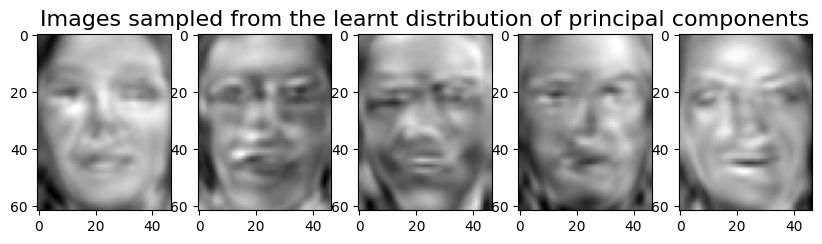

In [ ]:
samples_ = [sample_from_normal_() for _ in range(5)]

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from the learnt distribution of principal components", fontsize=16)
plt.show()

Hooray! The random “faces” might look pretty scary, but at least all that noise is gone, like we wanted.

### Reducing the temperature

A common trick to get more appealing output from generative models is to reduce the amount of randomness in the output. Let's reduce the entropy of the fitted distribution, to concentrate it on the most probable outcomes, and see what happens.

**Task 9.3.4:**<br/>
Re-implement the `sample_from_normal_` function above to take an argument `temperature` on $[0, 1]$ that scales the standard deviation proportionally. This is known as “reducing the temperature”. <font color="red"> (1 pts) </font>

In [ ]:
def sample_from_normal_(temperature=1):
    global X_j_mu_
    global X_j_std_
    assert 0 <= temperature <= 1, "The temperature parameter must be between 0 and 1."
    # YOUR CODE HERE
    Z = np.random.randn(*X_j_mu_.shape)
    return X_j_mu_ + Z * X_j_std_ * temperature

In [ ]:
# Please do not edit these testcases
np.random.seed(SEED)
test_sample_ = sample_from_normal_(temperature=1)
assert np.isclose(test_sample.mean(), 4.15971, atol=1e-4), "Did you set the location and scaling of the Gaussian correctly?"
assert np.isclose(test_sample.std(), 128.34241, atol=1e-4), "Invalid implementation, please check the scaling again."

test_sample_ = sample_from_normal_(temperature=0.5)
assert np.isclose(test_sample_.mean(), 1.20034, atol=1e-4), "The temperature has been used incorrectly. Check the implementation"
assert np.isclose(test_sample_.std(), 91.24741, atol=1e-4), "The temperature has been used incorrectly. Check the implementation"

Below are plots of output images sampled with different settings for the temperature parameter, namely 1, 0.25, and 0. The latter will give the maximally probable output under our model, which is the same very time.

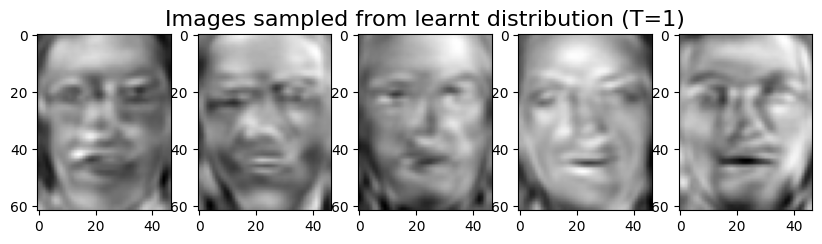

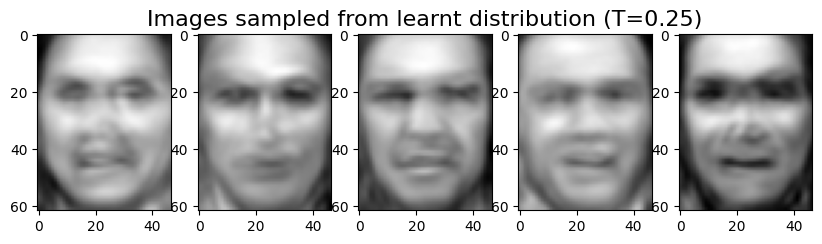

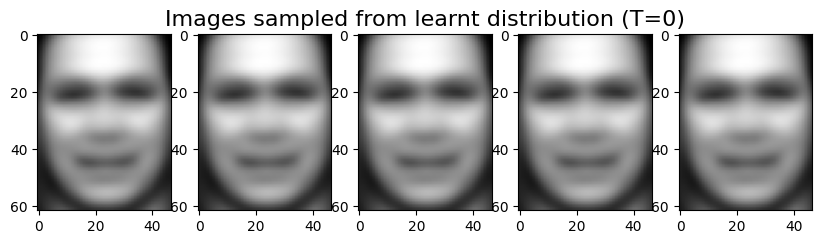

In [ ]:
samples_ = pca.inverse_transform([sample_from_normal_(1) for _ in range(5)])

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(samples_[i].reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from learnt distribution (T=1)", fontsize=16)
plt.show()

samples_ = pca.inverse_transform([sample_from_normal_(0.25) for _ in range(5)])

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(samples_[i].reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from learnt distribution (T=0.25)", fontsize=16)
plt.show()

samples_ = pca.inverse_transform([sample_from_normal_(0) for _ in range(5)])

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(samples_[i].reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from learnt distribution (T=0)", fontsize=16)
plt.show()

**Question 9.3.5**:<br/>
Did reducing the temperature improve the perceived quality? Give one or two sentences of motivation that describe what got better (or worse). <font color="red"> (1 pts)

It certainly looks less 'scary' at values at T=0.25 compared to T=1. There are less random artifacts to the faces, and they certainly look more human.

**Question 9.3.6**:<br/>
The images on the last row should look familiar. Where have you seen them before? Explain what happens when the temperature is 0. <font color="red"> (1 pts)

This is our 'average' face from the beginning of the exercise.

Despite the improvements from performing PCA, it is clear that the model is very far from perfect.

### Making the model non-Gaussian

Thus far we have only considered Gaussian models of the data. Since PCA is just a linear (or affine) transformation of the data, our model in PCA space also corresponds to a Gaussian model of images, just with a better description of how the pixels covary. In reality, however, the data is not Gaussian, and that allows for strong dependencies between the values of different PCA coefficients, even if the coefficients are uncorrelated.

To see that the image data isn't Gaussian, we will study eight different pixels (elements) on the primary diagonal of the original image data (no PCA). We plot a histogram for each pixel, showing the distribution of the brightness values of that pixel across the image data.

Primary diagonal pixels: [(0, 0), (4, 4), (8, 8), (12, 12), (16, 16), (20, 20), (24, 24), (28, 28)]


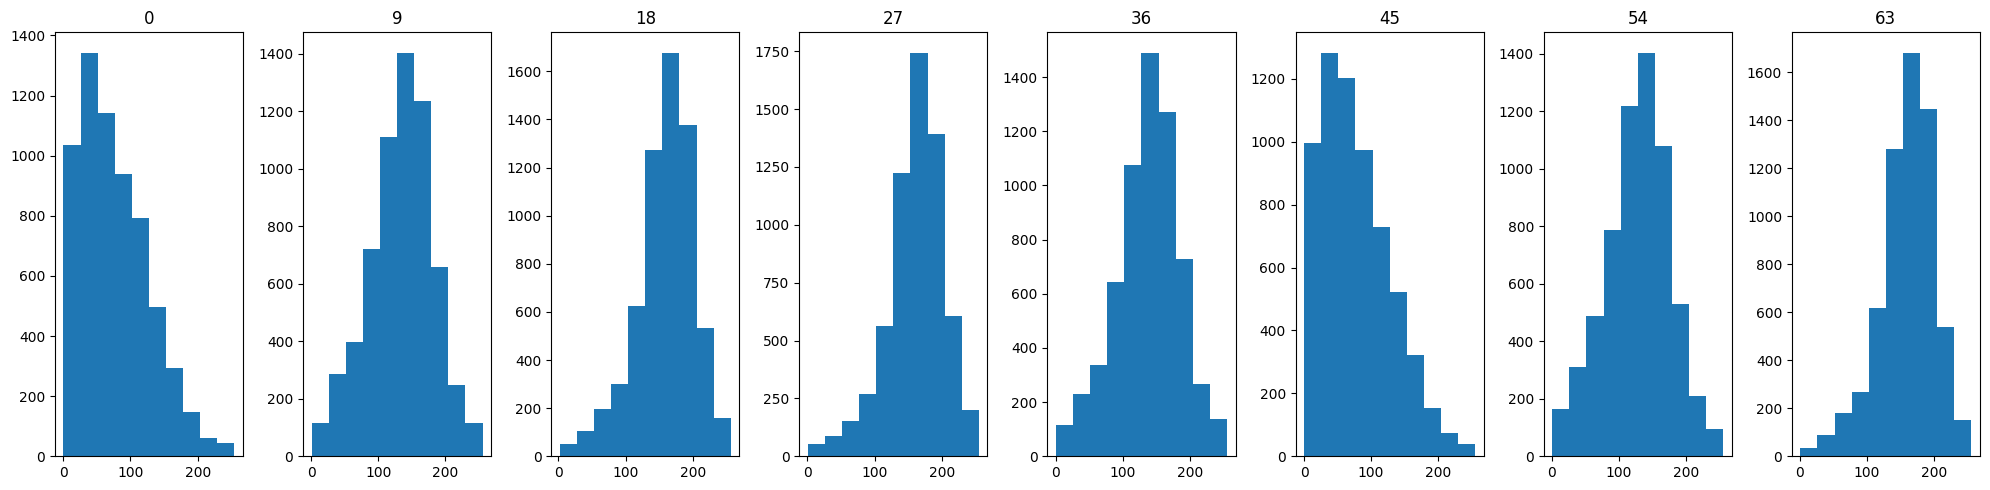

In [ ]:
diagonal = [(i, i) for i in range(image_shape[1])][0:30:4]
print(f"Primary diagonal pixels: {diagonal}")

fig, ax = plt.subplots(1, len(diagonal), figsize=(20,5))

for i in range(len(diagonal)):
    ax[i].hist(X[:, len(diagonal) * i + i])
    ax[i].set_title(len(diagonal) * i + i)

plt.tight_layout()
plt.show()

**Question 9.3.7**:<br/>
How can you tell from the histograms that these distributions are not Gaussian? Give one or two sentences of motivation. <font color="red"> (1 pts) </font>

The histograms have skew and are assymetric, implying they are likely not Gaussian.

To make progress, let's try to model the PCA data using a non-Gaussian distribution, namely a Gaussian mixture model.

In addition to being able to describe non-Gaussian distributions, a GMM also has the advantage that it can capture the correlations

Importantly, a GMM can in principle capture between pixels to an extent, via the mean vectors of different components. This is true even if each component has a diagonal covariance matrix.

In [ ]:
from sklearn.mixture import GaussianMixture

**Task 9.3.8**:<br/>
Train a number of GMMs with different number of components, on the PCA data `X_`. At the very least, train one model (`gmm25_`) with 25 components, and another (`gmm250_`) with 250 components. <font color="red"> (1 pts) </font>

_Hint:_<br/>
Use the scikit-learn implementation of GMMs (`GaussianMixture`), as imported above, and set `covariance_type='diag'` to use diagnonal covariance matrices for each component.

_Note:_<br/>
Because of the high dimentionality and the large dataset it might take some time to train these GMMs. However, training should be stable, since the scikit-learn implementation contains a variation of variance flooring. That said, there might still be a `ConvergenceWarning` or two.

In [ ]:
gmm25_ = None
gmm250_ = None

# YOUR CODE HERE
gmm25_ = GaussianMixture(n_components=25, covariance_type="diag")
gmm25_.fit(X_)
gmm250_ = GaussianMixture(n_components=250, covariance_type="diag")
gmm250_.fit(X_)

GaussianMixture(covariance_type='diag', n_components=250)

Let's take a look at some samples from these models and compare them to the previous Gaussian model.

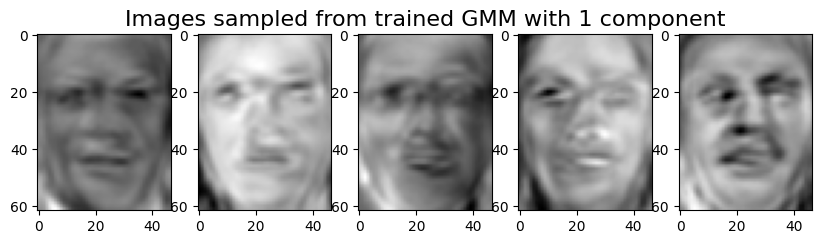

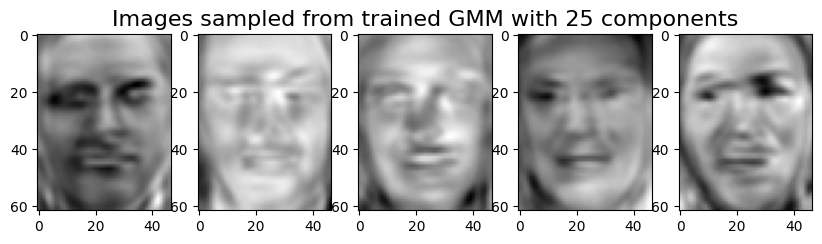

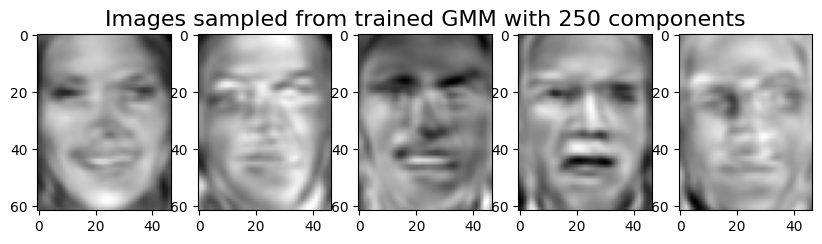

In [ ]:
samples_ = [sample_from_normal_(1) for _ in range(5)]

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 1 component", fontsize=16)
plt.show()

samples_, _ = gmm25_.sample(5)

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 25 components", fontsize=16)
plt.show()

samples_, _ = gmm250_.sample(5)

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 250 components", fontsize=16)
plt.show()

The faces are still not the greatest, so we can probably benefit from reducing the temperature when sampling.

The procedure that we used for a single Gaussian earlier is based on the temperature in the Gibbs measure, a concept that pops up in advanced probability theory and statistical physics, for example. We can't solve analytically for the distribution that results from any given Gibbs-measure temperature-reduction in a general Gaussian mixture distribution, but we can approximate the noise-reducing effect of temperature reduction by proportionally shrinking the covariance matrices of the different components. The code below implements that approximation.

In [ ]:
def samples_with_temperature(gmm, temperature=1, n_samples=5):
    """ Sklearn does not has a method/argument to do it so here is a hacky way of doing it"""

    assert 0 <= temperature <= 1, "The temperature parameter must be between 0 and 1."


    original_cov = gmm.covariances_.copy() # copying the original covariances
    gmm.covariances_ = gmm.covariances_ * temperature # Adjusting temperature
    samples, _ = gmm.sample(n_samples) # Sample
    gmm.covariances_ = original_cov # reset the temperature

    return samples

Let's plot some samples with reduced temperature.

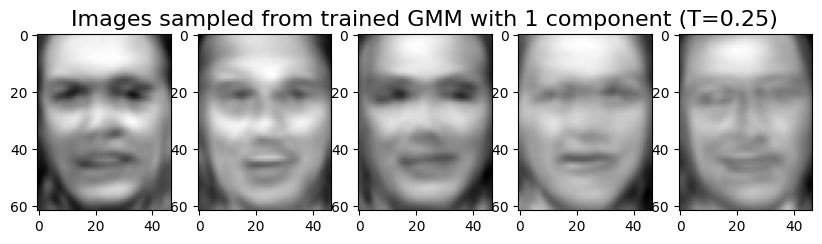

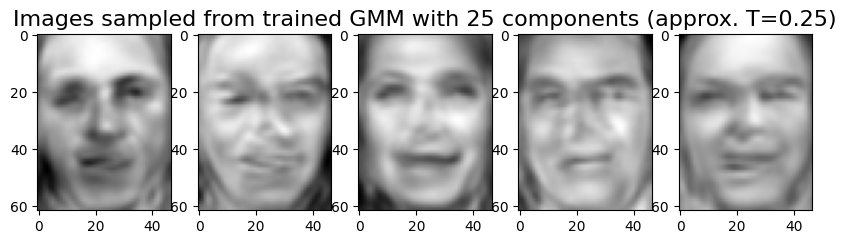

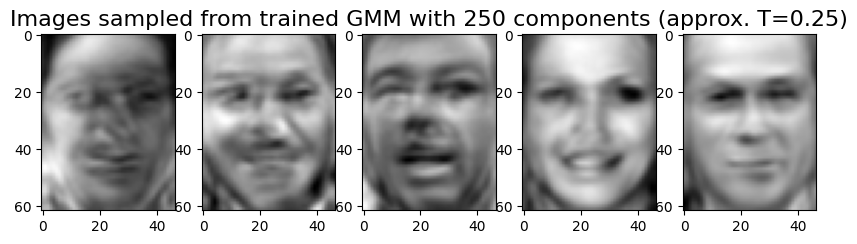

In [ ]:
samples_ = [sample_from_normal_(0.25) for _ in range(5)]

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 1 component (T=0.25)", fontsize=16)
plt.show()

samples_ = samples_with_temperature(gmm25_, 0.25, 5)

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 25 components (approx. T=0.25)", fontsize=16)
plt.show()

samples_ = samples_with_temperature(gmm250_, 0.25, 5)

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 250 components (approx. T=0.25)", fontsize=16)
plt.show()

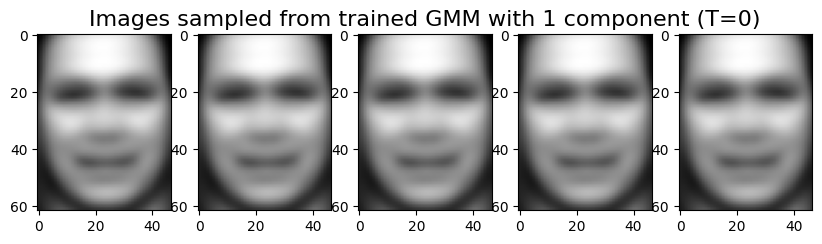

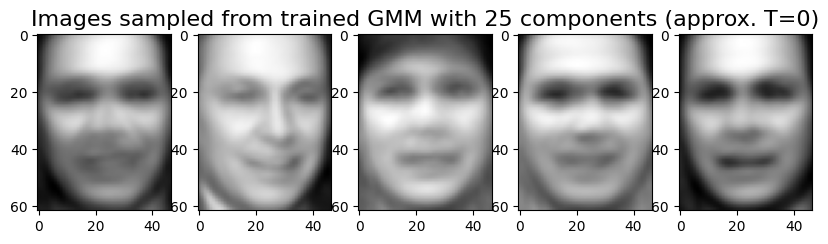

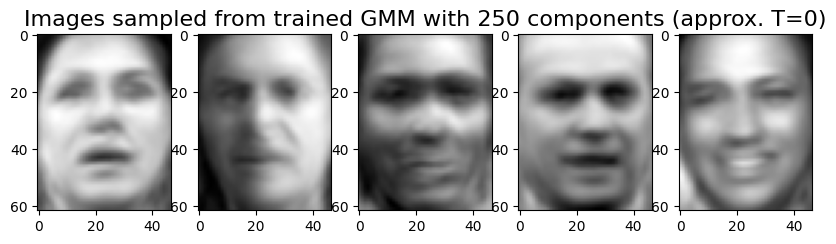

In [ ]:
samples_ = [sample_from_normal_(0) for _ in range(5)]

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 1 component (T=0)", fontsize=16)
plt.show()

samples_ = samples_with_temperature(gmm25_, 0, 5)

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 25 components (approx. T=0)", fontsize=16)
plt.show()

samples_ = samples_with_temperature(gmm250_, 0, 5)

fig, ax = plt.subplots(1, 5, figsize=(10, 6))
for i in range(5):
    plotting_axis = ax[i]
    plotting_axis.imshow(pca.inverse_transform(samples_[i]).reshape(image_shape), cmap='gray')
ax[2].set_title("Images sampled from trained GMM with 250 components (approx. T=0)", fontsize=16)
plt.show()

**Question 9.3.9**:<br/>
Why do the samples from GMMs with many components look less blurred? Explain in one or two sentences. <font color="red"> (1 pts) </font>

It may be capturing finer details in the more components, so we can see that they are able to present themselves here.

**Question 9.3.10**:<br/>
Why do the samples from many-component GMMs don't look exactly the same every time, even when we set the approximate temperature to 0? Explain in one or two sentences. <font color="red"> (1 pts) </font>

We choose from a gaussian in a probabilistic manner, with more components, its more likely to choose values from other distributions. (something not actually possible in the n = 1 case)

***A few things to think about:***

Why do the samples from GMMs with many components look less blurred?

Why do the samples from many-component GMMs don't look exactly the same every time, even when we set the approximate temperature to 0?

Although the models you have trained in this exercise are not very strong image-generation methods, we hope that you nontheless have gotten an impression of some of the basic principles of data generation, and what we can do to iteratively build better models and obtain better output.